In [1]:
import torch
from PIL import Image
from datasets import load_dataset
from pytorch_wavelets import DTCWTForward, DTCWTInverse
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor

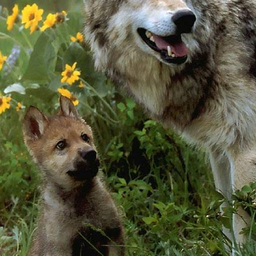

In [2]:
device="cuda"
train_dataset = load_dataset("danjacobellis/imagenet_hq", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=1,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [3]:
with torch.no_grad():
    xfm = DTCWTForward(J=5, biort='near_sym_b', qshift='qshift_b').to(device)
    X = valid_batch.clone()
    Yl, Yh = xfm(X)

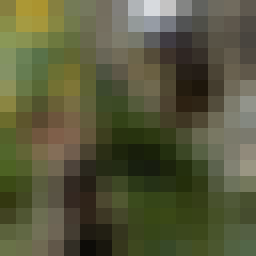

In [4]:
for img in Yl:
    display(ToPILImage()(img/16+0.5).resize((256,256),resample=Image.Resampling.NEAREST))

compenent 0


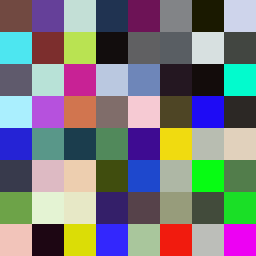

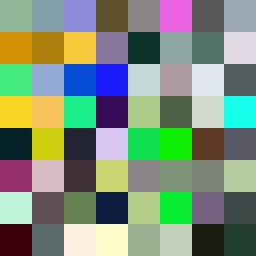

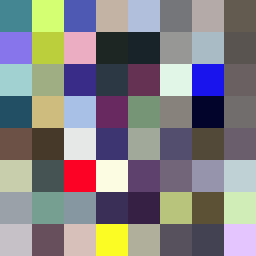

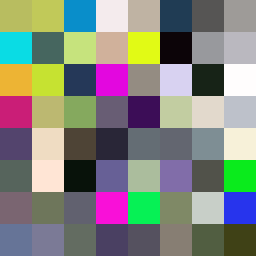

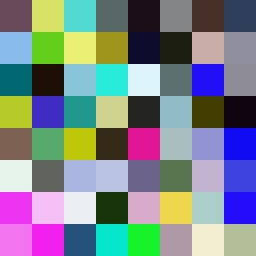

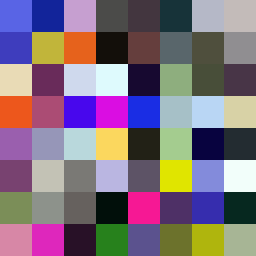

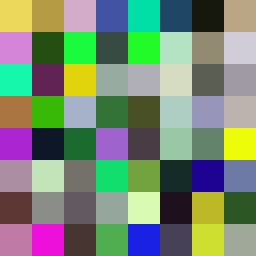

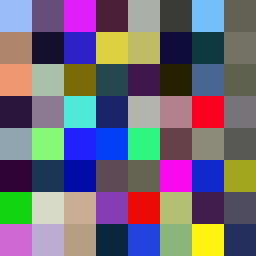

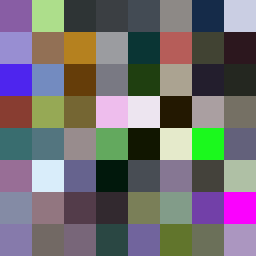

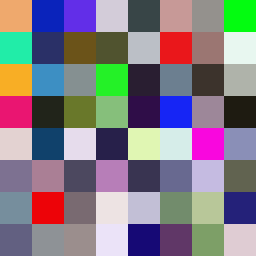

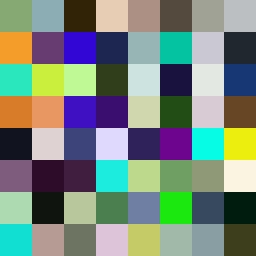

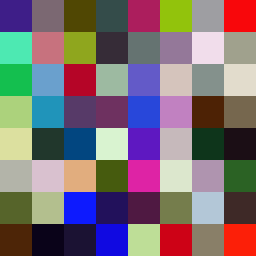

compenent 1


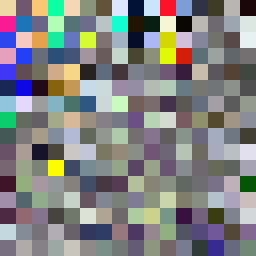

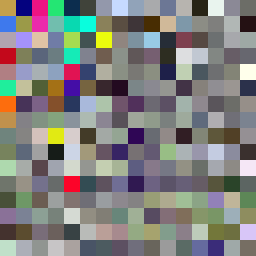

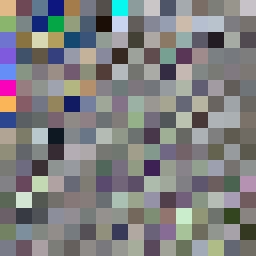

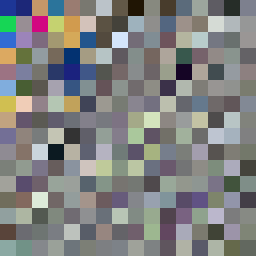

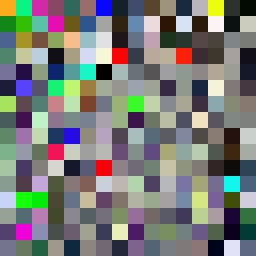

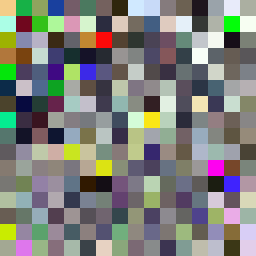

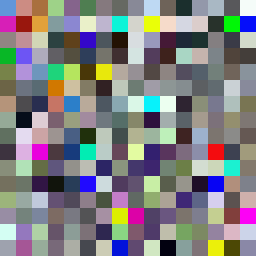

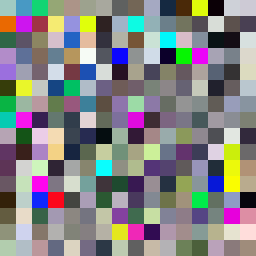

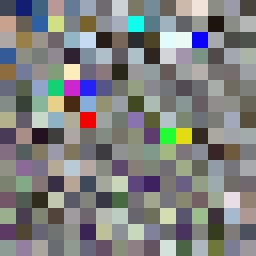

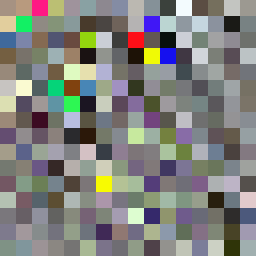

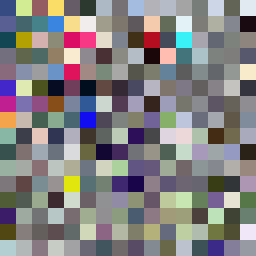

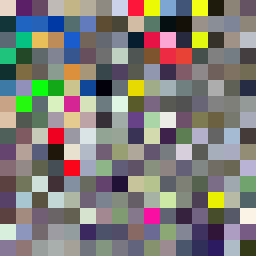

compenent 2


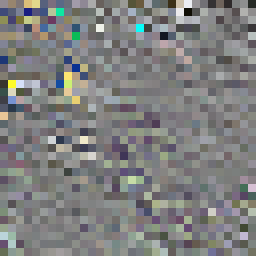

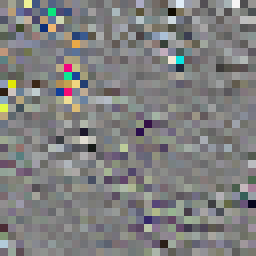

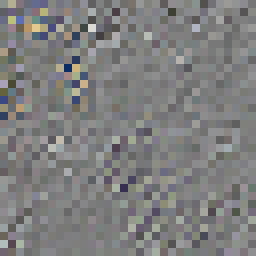

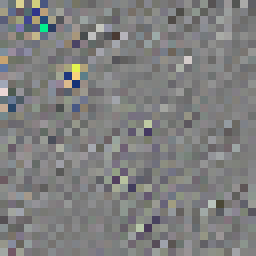

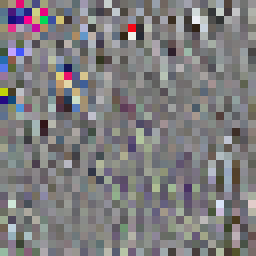

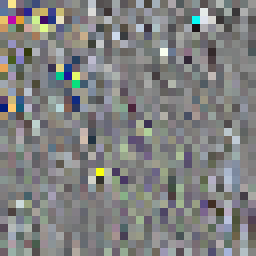

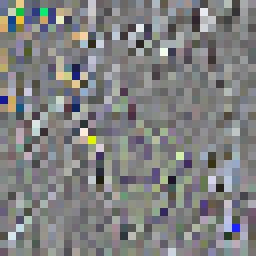

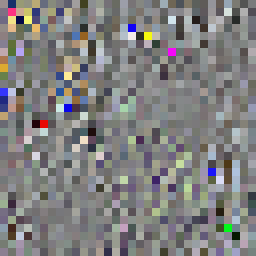

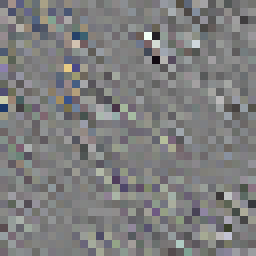

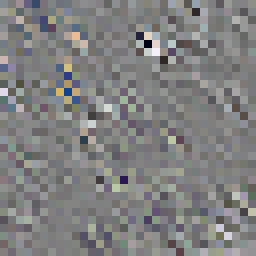

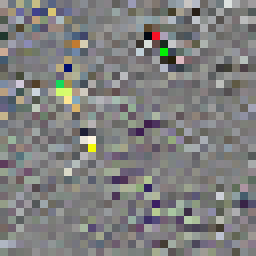

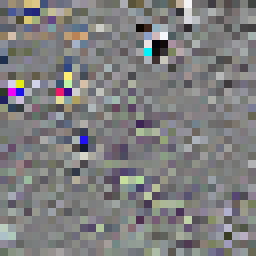

compenent 3


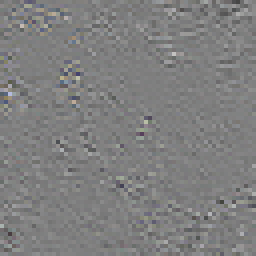

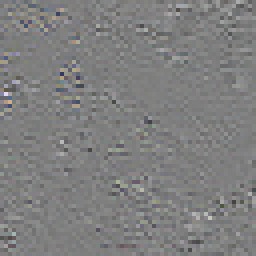

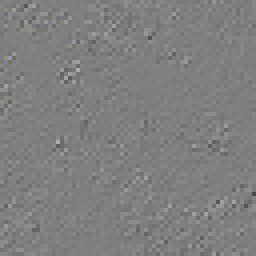

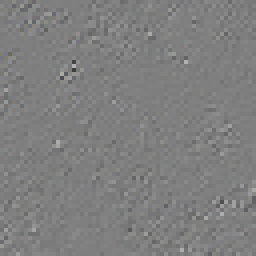

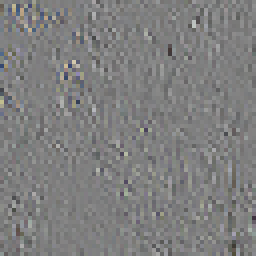

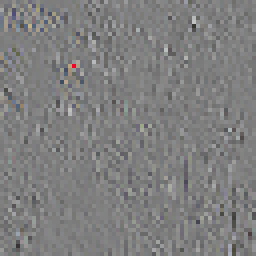

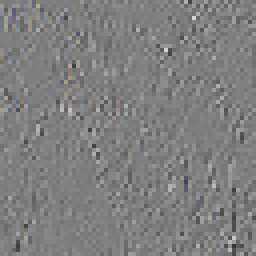

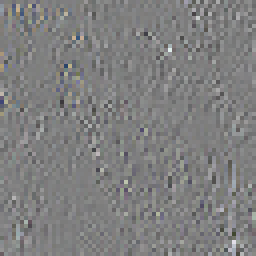

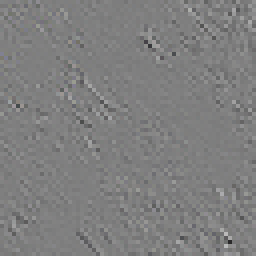

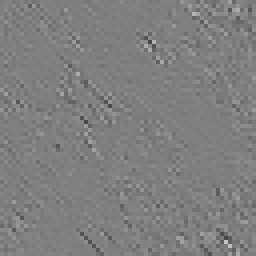

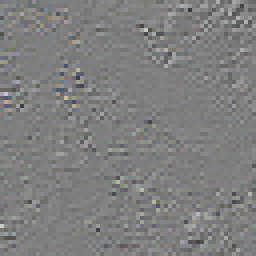

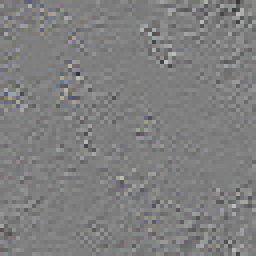

compenent 4


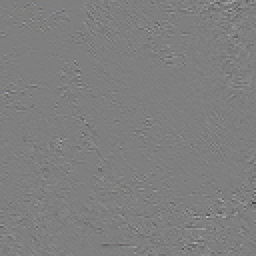

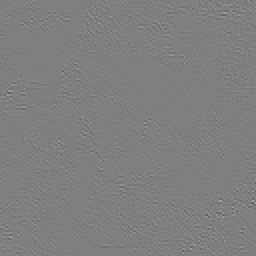

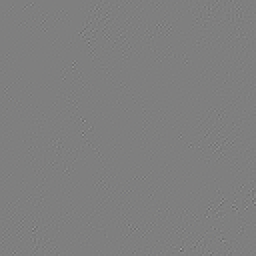

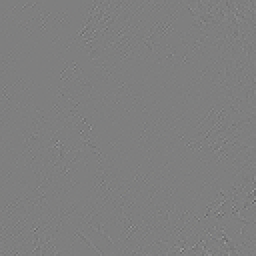

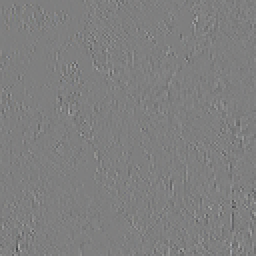

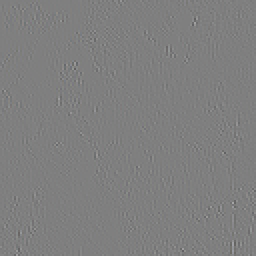

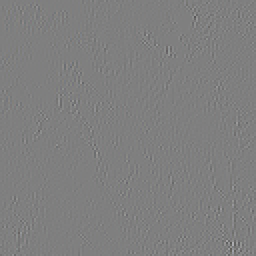

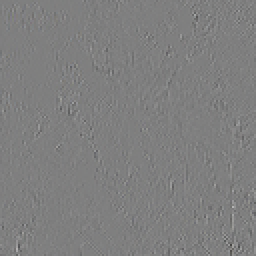

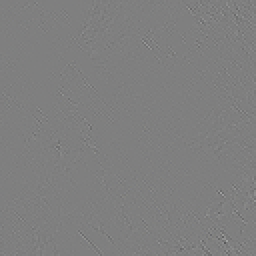

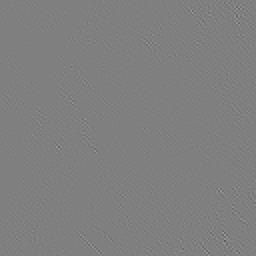

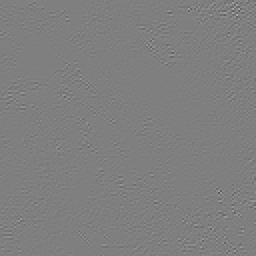

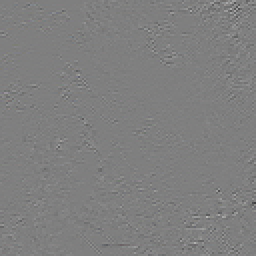

In [5]:
for i_component, component in enumerate(reversed(Yh)):
    print(f"compenent {i_component}")
    for img in component:
        for i_orientation in range(6):
            real_part = img[:,i_orientation,:,:,0].tanh()
            imag_part = img[:,i_orientation,:,:,1].tanh()
            display(ToPILImage()(real_part+0.5).resize((256,256),resample=Image.Resampling.NEAREST))
            display(ToPILImage()(imag_part+0.5).resize((256,256),resample=Image.Resampling.NEAREST))

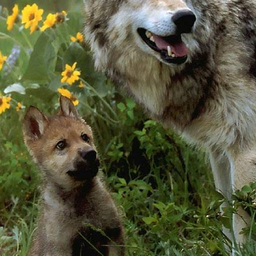

In [6]:
with torch.no_grad():
    ifm = DTCWTInverse(biort='near_sym_b', qshift='qshift_b').to(device)
    Y = ifm((Yl, Yh))

for img in valid_batch:
    display(ToPILImage()(img+0.5))